## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# read dataset
df = pd.read_csv('ab_data.csv')

# inspect dataset
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# we find the number of rows in the dataset
print('Number of columns : {}'.format(df.shape[1]))
print('Number of rows : {}'.format(df.shape[0]))

Number of columns : 5
Number of rows : 294478


c. The number of unique users in the dataset.

In [4]:
# unique users
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
# converted users using groupby
converted_users=df.groupby('converted').size()[1]/(df.groupby('converted').size()[0]+df.groupby('converted').size()[1])
print('The proportion of users converted is {0:0.2%} '.format(converted_users))

The proportion of users converted is 11.97% 


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# counting non-matching options

reason_a=df[(df['group'] == 'treatment')&(df['landing_page'] == 'old_page')].shape[0]
print('The number of times the new_page and treatment don\'t match because treatment and old page appear together are {} '.format(reason_a))

reason_b=df[(df['group'] == 'control')&(df['landing_page'] == 'new_page')].shape[0]
print('The number of times the new_page and treatment don\'t match because control and landing page appear together are {} '.format(reason_b))

total=reason_a+reason_b
print('The number of times the new_page and treatment don\'t match are {} '.format(total))

The number of times the new_page and treatment don't match because treatment and old page appear together are 1965 
The number of times the new_page and treatment don't match because control and landing page appear together are 1928 
The number of times the new_page and treatment don't match are 3893 


f. Do any of the rows have missing values?

In [7]:
# we check number of values in each rows using info function
# entry values denote if any column has missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


> No missing values!

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# drop rows where treatment and old page appear together
df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
# drop rows where control and landing page appear together
df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

In [9]:
df.head()
print('Number of rows : {}'.format(df.shape[0]))


Number of rows : 290585


In [10]:
df2=df.copy()

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

> Great!

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

In [12]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


a. How many unique **user_id**s are in **df2**?

In [13]:
#one way to get it
len(df2.user_id.unique())

290584

In [14]:
#or another way
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [15]:
# check if they exist
df2['user_id'].duplicated().any()

True

In [16]:
# check amount
df2['user_id'].duplicated().sum()

1

In [17]:
# who is?
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [18]:
# who is complete information
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
# dropping and keeping df2 as df2
df2=df2.drop_duplicates(['user_id'], keep='last')

In [20]:
# check again if they exist
df2['user_id'].duplicated().any()

False

In [21]:
# # check again amount 
df2['user_id'].duplicated().sum()

0

> Done! No duplicated users.

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [22]:
# calculate the proportion
p_conv=df2.groupby('converted').size()[1]/(df2.groupby('converted').size()[0]+df2.groupby('converted').size()[1])
print(' The probability of an individual converting regardless of the page they receive is {0:0.2%}'.format(p_conv))

 The probability of an individual converting regardless of the page they receive is 11.96%


b. Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
# calculate the proportion_ step 1_ amounts


amount_converted = df2.query ('converted == 1 ').count()[0]
amount_control = df2.query ('group=="control"').count()[0]
amount_converted_control = df2.query ('converted == 1  and group=="control"').count()[0]
                                                   
print('The amount of converted users is : {}'.format(amount_converted) )
print('The amount of control users is : {}'.format(amount_control) )
print('The amount of converted control users is : {}'.format(amount_converted_control) )

The amount of converted users is : 34753
The amount of control users is : 145274
The amount of converted control users is : 17489


In [24]:
# calculate the proportion_ step 2_ proportion itself

converted_control=amount_converted_control/amount_control
print( 'The probability of an individual that is in control group to convert is : {0:0.2%}'.format(converted_control))

The probability of an individual that is in control group to convert is : 12.04%


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [25]:
# calculate the proportion_ step 1_ amounts

amount_converted = df2.query ('converted == 1 ').count()[0]
amount_treatment = df2.query ('group=="treatment"').count()[0]
amount_converted_treatment = df2.query ('converted == 1  and group=="treatment"').count()[0]
                                                   
print('The amount of converted users is : {}'.format(amount_converted) )
print('The amount of treatment users is : {}'.format(amount_treatment) )
print('The amount of converted treatment users is : {}'.format(amount_converted_treatment) )

The amount of converted users is : 34753
The amount of treatment users is : 145310
The amount of converted treatment users is : 17264


In [26]:
# calculate the proportion_ step 2_ proportion itself

converted_treatment=amount_converted_treatment/amount_treatment
print( 'The probability of an individual that is in treatment group to convert is : {0:0.2%}'.format(amount_converted_treatment/amount_treatment))

The probability of an individual that is in treatment group to convert is : 11.88%


d. What is the probability that an individual received the new page?

In [27]:
# calculate the probability_ step 1_ amount of user who recive old site
amount_old=df2.query('landing_page == "old_page"').count()[0]
print('The amount of users who recive the old page is: {}'. format(amount_old))
# calculate the probability_ step 2_ amount of user who recive new site
amount_new=df2.query('landing_page == "new_page"').count()[0]
print('The amount of users who recive the new page is: {}'. format(amount_new))
# calculate the probability_ step 3_ total number of users
total=df2.shape[0]
print('The total number of users is: {}'. format(total))

print('The probability that an individual received the new page is: {0:0.5%}'.format(amount_new/total))

The amount of users who recive the old page is: 145274
The amount of users who recive the new page is: 145310
The total number of users is: 290584
The probability that an individual received the new page is: 50.00619%


> The proportions of each page are balanced !

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> We have obtained that:
 - The probability of an individual that is in control group to convert is : 12.04%
 - The probability of an individual that is in treatment group to convert is : 11.88%
 
 
> So, **the margin is too narrow to let us conclude in any direction.** We cannot say  that the old page does better and of course we have not any evidence that the oppiste conclusion is true. So **we need to find more clear evidences.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.


**$H_{0}:$** **$p_{new}$** - **$p_{old}  \leq  0  $**

>This is the null hypothesis, the one we assume to be true by default. It means that the old page is better or equal than the new.


**$H_{1}:$** **$p_{new}$** - **$p_{old}  \gt   0  $**

>This is the alternative hypothesis, the one we try to reject/accept. 



`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [28]:
# according to the wording, we assume that p_new=p_old=p_conv from 4.a
p_new = p_conv
p_new


0.11959708724499628

In [29]:
#of course , it can be obtained as:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [30]:
# the same value
p_old=p_new
p_old

0.11959708724499628

In [31]:
print('RESULTS')
print('p_new is equal to : {}'.format(p_new))
print('p_old is equal to : {}'.format (p_old))


RESULTS
p_new is equal to : 0.11959708724499628
p_old is equal to : 0.11959708724499628


c. What is $n_{new}$, the number of individuals in the treatment group?

In [32]:
# i print the table only to have it in mind
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [33]:
# count the number of individuals in the treatment group 

n_new = df2.query('group == "treatment"')
len(n_new)


145310

In [34]:
# as well, I could get it with landing_page and new_page because in the last seccion we have assured
# that all new_pages go to treatment group.

n_new = df2.query('landing_page == "new_page"')
len(n_new)

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [35]:
# the way to get is the same as in the last seccion:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [36]:
# to do so, with the ----numpy.random.choice(a, size=None, replace=True, p=None)------ function
# where [0, 1] : are the possible options --converting or not
# size=len(n_new) is how huge is the sample
# and p=[(1 - p_new), p_new] are the probabtilities associated to the 0 and 1
# this way we simplate a sample with a conversion probability obtained from the excel data collect

new_page_converted = np.random.choice([0, 1], size=len(n_new), p=[(1 - p_new), p_new])

print ('We have obtained the following array: {}'. format(new_page_converted))

# in order to get the conversion probability , as we have been using, we calculate the mean 
# of the convertions

p_convert_sample_new=new_page_converted.mean()

print( 'The conversion rate to convert the NEW PAGE is {}'. format(p_convert_sample_new) )


We have obtained the following array: [0 0 0 ..., 0 0 0]
The conversion rate to convert the NEW PAGE is 0.1186016103502856


f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [37]:
# we proceed the same way for the old page recivers.

old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_new), p_new])

print ('We have obtained the following array: {}'. format(old_page_converted))

# in order to get the conversion probability , as we have been using, we calculate the mean 
# of the convertions

p_convert_sample_old=old_page_converted.mean()

print( 'The conversion rate to convert the NEW PAGE is {}'. format(p_convert_sample_old))

We have obtained the following array: [0 0 0 ..., 0 0 0]
The conversion rate to convert the NEW PAGE is 0.11910596527940306


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [38]:
# p_new - p_old  ... 
p_convert_sample_new - p_convert_sample_old

-0.00050435492911746205

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [39]:
# in order to generate a sampling distribution , we go on with repeating the previous sample proces 10000 times.
# I use a variable called p_diffs

start_time = time.time()

p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size=len(n_new), p=[(1 - p_new), p_new])
    old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_new), p_new])
    p_convert_sample_new=new_page_converted.mean()
    p_convert_sample_old=old_page_converted.mean()
    p_diffs.append(p_convert_sample_new - p_convert_sample_old)



print("\nThis took %s seconds." % (time.time() - start_time))



This took 70.89159727096558 seconds.


In [40]:
# I store the variable in an array called p_diffs

p_diffs = np.array(p_diffs)
print(p_diffs)

# I could now, for example know things about the new distribution.

print(' The mean of the sampling distribution for p_new - p_old is:{}'.format(p_diffs.mean()))

[ 0.00267537 -0.00029829 -0.00020176 ...,  0.00145689  0.00232439
  0.00030778]
 The mean of the sampling distribution for p_new - p_old is:1.3604360380907318e-05


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

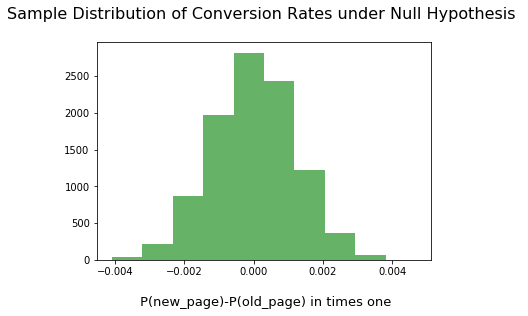

In [41]:
# I print an histogram to see how the sample distribution appear to shape

plt.hist(p_diffs, alpha=.6, color='green')

print()
plt.title("Sample Distribution of Conversion Rates under Null Hypothesis \n", fontsize=16, alpha=1)
plt.xlabel("\n P(new_page)-P(old_page) in times one", fontsize=13);
print()

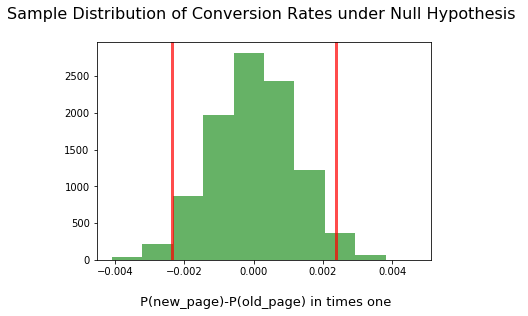

In [42]:
# In order to go a bit further I look at the 95% confidence interval

plt.hist(p_diffs, alpha=.6, color='green')

print()

plt.title("Sample Distribution of Conversion Rates under Null Hypothesis \n", fontsize=16, alpha=1)
plt.xlabel("\n P(new_page)-P(old_page) in times one", fontsize=13);

low_limit, upper_limit = np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)
low_limit, upper_limit

plt.axvline(x=low_limit, color='red', linewidth=3, alpha=0.7);
plt.axvline(x=upper_limit, color='red', linewidth=3, alpha=0.7);

print()

In [43]:
# the values for the bounds are:
print('low_bound: {} and upper_bound: {}'. format(low_limit, upper_limit))

low_bound: -0.0023630284416610867 and upper_bound: 0.0023658728314574938


>so, we can affirm **according to the Central Limit Theorem**

> We are **95% confident**, the mean of the difference between the conversion rates between new and old page falls **between -0.0023424159241253947 and 0.002372446535636323**

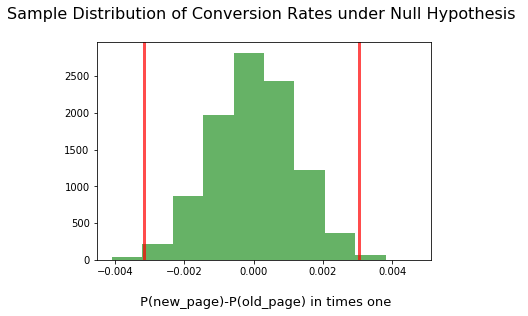

In [44]:
# To achieve a 99% confidence 

plt.hist(p_diffs, alpha=.6, color='green')

print()

plt.title("Sample Distribution of Conversion Rates under Null Hypothesis \n", fontsize=16, alpha=1)
plt.xlabel("\n P(new_page)-P(old_page) in times one", fontsize=13);

low_limit, upper_limit = np.percentile(p_diffs, 0.5), np.percentile(p_diffs, 99.5)
low_limit, upper_limit

plt.axvline(x=low_limit, color='red', linewidth=3, alpha=0.7);
plt.axvline(x=upper_limit, color='red', linewidth=3, alpha=0.7);

print()

In [45]:
# the values for the bounds are:
print('low_bound: {} and upper_bound: {}'. format(low_limit, upper_limit))

low_bound: -0.0031614521933184606 and upper_bound: 0.0030467991857231866


>so, we can affirm **according to the Central Limit Theorem**

> We are **99% confident**, the mean of the difference between the conversion rates between new and old page falls **between -0.0030445357422345643 and 0.0031294825592690823**

> And this result suggest that failing to reject **$H_{0}$** is a plausible option.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [46]:
# We start by adding the value of the diference between converted_treatment - converted_control

obs_diff=converted_treatment - converted_control
obs_diff

-0.0015782389853555567

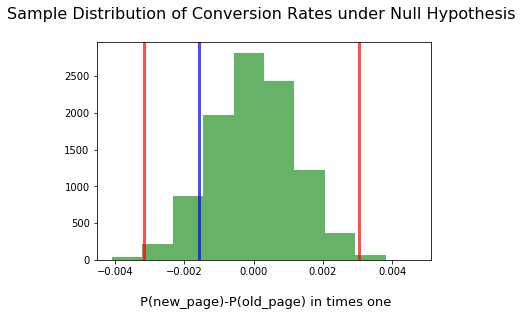

In [47]:
# print 99% confidence line and observed difference in orange

plt.hist(p_diffs, alpha=.6, color='green')

print()

plt.title("Sample Distribution of Conversion Rates under Null Hypothesis \n", fontsize=16, alpha=1)
plt.xlabel("\n P(new_page)-P(old_page) in times one", fontsize=13);

low_limit, upper_limit = np.percentile(p_diffs, 0.5), np.percentile(p_diffs, 99.5)
low_limit, upper_limit

plt.axvline(x=low_limit, color='red', linewidth=3, alpha=0.7);
plt.axvline(x=upper_limit, color='red', linewidth=3, alpha=0.7);
plt.axvline(converted_treatment - converted_control, linewidth=3, alpha=0.7, color= 'blue');

print()

> Well, the thing we have to do now is calculating the p-value. P-value is the area of the green shaded normal sampling distribution. But, which area? 


>Here is where we consult our alternate hypothesis and look at the direction of the arrow. If the sign is greater than (with the tail pointing to the right), then we need to calculate the shaded area to the right of our observed value (the blue line), or the proportion of values from our null distribution that are greater than the observed mean.That is why we are asked about the  proportion of the p_diffs are greater than the actual difference observed )


>This compares each value in the distribution to obs_diff and creates an array of these comparisons (For each comparison, if the  value created under the null is greater than the observed statistic, the result will be True, if not, it will be False). When calculating the mean, comparisons that were True are evaluated as 1 and comparisons that were False are evaluted as 0.


> And what p-value represents? It shows the probability that what we have observed (the statistic) may be a parameter of the population ASSUMING as true the null hypothesis.

In [48]:
# shaded area at the right side of the blue line
p_val = (p_diffs > obs_diff).mean()
p_val

0.9052

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> The calculated p-value is 0.9065. This is clearly high!! It means that **we have not enough evidence to reject the null.** Therefore, we can not assume  differences in the population's reaction to a new page compared to an old one. **In other words: We have not enough evidences that new pages produce more conversions than the old ones.**

>Obviously, the p-value is higher than Error I (of $ \ alpha $) of 0.05 or 0.01.A $ \ alpha $ level of 0.05 indicates that we have a 5% chance of making a Type I error if the null is true and we reject it ( this is not the case because we are confident with our no rejection status) 



l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [49]:
# prepare to use ztest 

import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]
print(convert_old, convert_new, n_old, n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [50]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>A z_score is the number of standard deviations away from the mean that the element is. A z_score of 1.311 lies between the 1st and 2nd standard deviations. In probability and statistics, 1.96 is the approximate value of the 97.5 percentile point of the normal distribution. So, assuming as a critic z-value 1.96  and given that we our result is under the critic z-value we cannot reject the null and afirm that the old_page is the same or better than the new_page.

>0.9051 > 0.05. With a p_value of .9051 we accept the null hypothesis. That is the old_page is the same or better than the new_page.


>Yes, p_values are very similar. In the ztest they are 0.9051 and with the simulation the p_value was 0.9084. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>As is a matter of predictinc if **is either a conversion or no conversion**, the outcome has only 2 possible options. So, the best option 
is **logisitic regression.**



b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [51]:
# create intercept and dummies
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['group'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [52]:
#  instantiate the regression
logit_regression = sm.Logit(df2['converted'], df2[['ab_page', 'intercept']])
results = logit_regression.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [53]:
#get results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               8.077e-06
Time:                        00:17:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


> The p-value is 0.190 , this means that the probability of commiting a Error type-I is high and 
**$H_{0}$** cannot be rejected.

>The reason could come from the fact that now we have:



>**$H_{0}:$** **$p_{new}$** - **$p_{old}  =  0  $**

>**$H_{1}:$** **$p_{new}$** - **$p_{old}  \neq   0  $**



>And in part 2 we used



>**$H_{0}:$** **$p_{new}$** - **$p_{old}  \leq  0  $**

>**$H_{1}:$** **$p_{new}$** - **$p_{old}  \gt   0  $**

>Therefore **this test calculates the probability (area) using the two tails.**


>Let's **calculate using the bootstrap** technique.

In [54]:
# Calculate area at the left
p_left = (p_diffs < obs_diff).mean()

# Calculate area at the right
right = p_diffs.mean() - obs_diff
p_right = (p_diffs > right).mean()

# Calculate total area
print('The total area is: {0:0.1%}'.format (p_left + p_right))

The total area is: 19.0%


>**18.4 % is similar to 19%** obtained with Logit Regression, so this could be probably the reason.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>There are **some other factors** that could affect the result. For example:
- The **testing time** colud be too long or maybe too short for the experiment.
- External factors as **holidays** can disguise the traffic.
- Sale **periods with high consumism rate** and few money.
- **Origin from the visitors** (correspond or not to matriculation period of the year).
- And issues than can lead to a **Simpson's paradox, specially if the experiment settings change enough during the experiment** to make the weight of a varibale change dramatically.

>**The main problem to add additional terms is multicollinearity.** The problem comes when independent variables in a regression model are correlated and they should be independent . And , if the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results.


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [55]:
# We start by loading the countries dataset

df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [56]:
# Even it is stated, let's check how many countries appear
df_countries['country'].nunique()

3

so, I need two columns!

In [57]:
# which ones?
df_countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [58]:
# But, first we have to merge the two dataframes
# To do that :
df_merged = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1


In [59]:
# and now we add the dummies
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0


Logit model instantion

In [60]:
# As we ara asked to add an effect based on which country a user lives in, 
# we create a multiple regression with ab_page and the countries.
df_merged['intercept'] = 1
logit_regression = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA', 'UK','ab_page']])
results = logit_regression.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:17:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0042      0.009   -224.560      0.000      -2.022      -1.987
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
==============================================================================
"""

> the p-values over 0.05, so no argument to reject the null.

In [61]:
df_merged['intercept'] = 1
logit_regression = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US', 'ab_page']])
results = logit_regression.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:17:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0450      0.027    -76.820      0.000      -2.097      -1.993
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
==============================================================================
"""

> the p-values over 0.05, so no argument to reject the null.

In [62]:
df_merged['intercept'] = 1
logit_regression = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA', 'US', 'ab_page']])
results = logit_regression.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:17:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9943      0.013   -156.012      0.000      -2.019      -1.969
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
ab_page        0.0149      0.011      1.307      0.191      -0.007       0.037
==============================================================================
"""

>the p-values over 0.05, so no argument to reject the null.

> We fail to reject the null because p-values are all above 0.05. there is no significant contribution from country to differences in conversion rates for the two pages. So, we can afirm that the new page is not different in terms of conversion rate than the old one ( attendid the experiment conditions)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

> First of all we crate the interaction terms.

In [63]:
df_merged['US_page'] = df_merged['ab_page']*df_merged['US'] 
df_merged['UK_page'] = df_merged['ab_page']*df_merged['UK']
df_merged['CA_page'] = df_merged['ab_page']*df_merged['CA']

df_merged.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,US_page,UK_page,CA_page
user_id,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,1,1,0,0,1,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,1,0,1,0,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,1,0,1,0,0,0,0


> Once they are created, we check if there are significant effects on conversion.

In [64]:
df_merged['intercept'] = 1
logit_regression = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page','CA_page', 'UK_page' , 'CA', 'UK']])
results = logit_regression.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:               3.482e-05
Time:                        00:17:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0070      0.010   -207.045      0.000      -2.026      -1.988
ab_page        0.0206      0.014      1.505      0.132      -0.006       0.047
CA_page        0.0469      0.054      0.872      0.383      -0.059       0.152
UK_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA            -0.0644      0.038     -1.679      0.093      -0.140       0.011
UK             0.0257      0.019      1.363      0.173      -0.011       0.063
==============================================================================
"""

> Again, we fail to reject the null because p-values are all above 0.05. 

>There is no significant contribution from the interations that can be seen in terms of conversion rates. So, we can afirm that the new page is not different in terms of conversion rate than the old one (attendid the experiment conditions)

To end up this section, we can as well computing the VIF (Variance Inflation Factor) in order to evaluate a possible Multicollinearity. 

In [65]:
from patsy import dmatrices

from statsmodels.stats.outliers_influence import variance_inflation_factor


y, X = dmatrices('converted ~ CA +  CA_page + ab_page + UK_page + UK ', df_merged, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,2.851575,Intercept
1,2.021987,CA
2,2.074599,CA_page
3,1.427098,ab_page
4,2.380800,UK_page
5,2.040305,UK


> As all VIF are clearly under 10 we can assume that there is **NOT** a state of very high intercorrelations or inter-associations among the independent variables.

> It is clear that from this part of Regression Analysis that no one of the p-values indicate that we fail to reject the null and conclude that there isn't significant evidence that there is an interaction between country and page received that will predict conversion.

<a id='conclusions'></a>

## Conclusions

> 1. The objective of this study has been to identify if in a statistically significant way, we could affirm that the new Web will provoke more conversions than the old one. Through an A / B analysis we have verified that **data give not enough evidence to afirm that the new page causes more conversions than the old one.**

> 2. **The study does NOT indicate that the old page is better**. What the study really indicates is that we can not affirm with sufficient statistical significance that the new website generates more conversions.

In [66]:
print(min(df_merged['timestamp']))
print(max(df_merged['timestamp']))


2017-01-02 13:42:05.378582
2017-01-24 13:41:54.460509


> 3. **The experiment has been conducted under certain conditions that should be analyzed and evaluated**. For example, it has been put to test during  February of the year 2017 during 22 days with users from the UK, US and CA. These and other limitations/characteristics  must be analyzed before accepting the results.

> 4. So, to end up,  we were asrked to  help an e-commerce website to understand the results of an A/B test. The goal was to to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision. So, **after the entire analyse, the recomendation for the company regarding the e-commerce website** would be to **run the experiment longer to make their decision**.

In [67]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0